# **Udacity Capstone Project: Sparify**

# Part 1: Project Overview and Problem Statement

Many online services make use of subscriptions where users pay monthly for a product that they are using. When the platform is online, it can be profitable to implement a "freemium" model where the service is free to the population (usually with ads) and the subscription allows for the removal of ads.

In such situations, being able to predict when a user will unsubscribe so that they can be targeted with promotions to try and convince them to stay can reduce loss of potential revenue over time. In this dataset, the actions for a given user have been recorded and will be used towards this end.

However, online platforms tend to generate high volumes of data that can be difficult to keep in memory. Big data solutions such as Spark can help to distribute the workload among several computers, allowing machine learning to be done on larger datasets.

Thus, we will use Spark in this project to help with our aim of creating a ML model to predict churn on a user level.

# Part 2: Preparatory Analysis

Before doing any machine learning, it is important to load the dataset, perform some cleaning, and do some basic investigation.

Depending on correlations, we can decide which features we would like to use in our model (feature selection) and we can also decide which features can be combined or infered to create new features that might provide useful information (feature engineering).


## Data Importation and Workspace Setup

Below, packages required for this problem will are imported as well as other prepwork for the project.

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Cleaning and analysis will be done on this smaller dataset before doing anything with the larger dataset.

### Import Libraries

In [105]:
# import libraries
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col

from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import matplotlib.pyplot as plt

plt.style.use("seaborn")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Define Functions

In [125]:
def print_cm(tp, tn, fp, fn, print_cm=True, return_cm=False):
    """
    Print confusion matrix given tp, tn, fp and fn.
    
    Note that array is in following order tp, fp, fn, tn. (Row, across)
    
    :Inputs:
        :tp: Int, True positives
        :tn: Int, True Negatives
        :fp: Int, False Positives
        :fn: Int, False Negatives
        :print_cm: Bool, if true then prints cm
        :return_cm: Bool, if true then returns cm
    :Returns:
        :cm: Confusion matrix as numpy array
    """
    
    cm = np.array([[tp, fp],
                   [fn, tn]])

    if print_cm:
        print(cm)
    
    if return_cm:
        return cm

In [122]:
def get_classification_score(tp, tn, fp, fn, print_stats=True, return_stats=False):
    """
    Prints classification scores given tp, tn, fp and fn.
    
    :Inputs:
        :tp: Int, True positives
        :tn: Int, True Negatives
        :fp: Int, False Positives
        :fn: Int, False Negatives
        :print_stats: Bool, if true then prints stats
        :return_stats: Bool, if true then returns stats
    :Returns:
        :accuracy: Number of correct classifications over number of classifications
        :precision: Number of true positives out of positive classifications
        :recall: Number of true positives out of those that should have been true positives
        :f1: Harmonic mean of precision and recall, good overall stat
    """
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    try: precision = tp / (tp + fp) 
    except ZeroDivisionError: precision = np.NaN

    try: recall = tp / (tp + fn)
    except ZeroDivisionError: recall = np.NaN

    f1 = 2*precision*recall / (precision+recall)

    if print_stats:
        print("_________________")
        print("Confusion Matrix:")
        print("\tAccuracy:", accuracy)
        print("\tPrecision:", precision)
        print("\tRecall:",recall)
        print("\tF1 Score:", f1)
        print("_________________")
        
    if return_stats:
        return accuracy, precision, recall, f1

### Spark Setup

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist();

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

We can already see that there are 12 columns in our data set.

## Data Cleaning

### First Looks

Now that the data has been imported, the first and most obvious thing to check for is missing and duplicated values. 

Since I am relatively comfortable with SQL, I will try and use that a little. In order to do that I need to create a temp view within the spark object that created the dataframe using the `createOrReplaceTempView` method.

In [6]:
# Create Temp View
df.createOrReplaceTempView("df")

Now that this is complete, we can look at the null values for each column.

In [7]:
null_dict = {}

for i in df.columns:
    
    nulls = spark.sql("SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS null_{} \
                    FROM df \
                    where {} is null".format(i, i, i)).collect()[0]["null_{}".format(i)]
    
    print(i, nulls)
    null_dict[i] = nulls

artist 58392
auth None
firstName 8346
gender 8346
itemInSession None
lastName 8346
length 58392
level None
location 8346
method None
page None
registration 8346
sessionId None
song 58392
status None
ts None
userAgent 8346
userId None


We can see that there are 58k rows where the artist and song names are null. This could be because in this instance, the page that was visited was not intended to play a song. 

We can also see that there are several columns which are never null;

* auth
* itemInSession
* level
* method
* page
* sessionId
* status
* ts
* userId

This tells us that we have users who commit actions during a session. So, the unique key should be something like (userId, ts). We can quickly verify that:

In [8]:
# Test for unique key
spark.sql("SELECT userId, ts, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2\
        HAVING count(*) > 1 \
        ORDER BY 3 DESC \
        LIMIT 10").collect()

[Row(userId='98', ts=1538838475000, n_rows=3),
 Row(userId='95', ts=1539665400000, n_rows=3),
 Row(userId='100022', ts=1541463867000, n_rows=3),
 Row(userId='', ts=1538488477000, n_rows=2),
 Row(userId='118', ts=1540521007000, n_rows=2),
 Row(userId='152', ts=1543206099000, n_rows=2),
 Row(userId='30', ts=1543436963000, n_rows=2),
 Row(userId='36', ts=1539070836000, n_rows=2),
 Row(userId='9', ts=1539714540000, n_rows=2),
 Row(userId='132', ts=1542791668000, n_rows=2)]

In [9]:
# Find number of userid-timestamp combinations that have duplicated rows
spark.sql("WITH T AS (SELECT userId, ts, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2\
        HAVING COUNT(*) > 1 \
        ORDER BY 3 DESC \
        ) \
        SELECT COUNT(*) FROM T").collect()

[Row(count(1)=783)]

### Remove Duplicates

We can see here that my assertion was wrong and that we have almost 800 userId-ts combinations that have at least 2 entries. We can view an example as well using the query below...

In [10]:
# Get an example with duplicated rows
spark.sql("SELECT * \
        FROM df \
        WHERE userId = 98\
        AND ts = 1538838475000").collect()

[Row(artist='Mase', auth='Logged In', firstName='Sawyer', gender='M', itemInSession=70, lastName='Larson', length=255.16363, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=493, song="Lookin' At Me [feat. Puff Daddy] (Album Version)", status=200, ts=1538838475000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist=None, auth='Logged In', firstName='Sawyer', gender='M', itemInSession=71, lastName='Larson', length=None, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='GET', page='Home', registration=1538069638000, sessionId=493, song=None, status=200, ts=1538838475000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist=None, auth='Logged In', firstName='Sawyer', gen

In this example we can see that the user went to the next song before visiting the home page twice all with the same timestamp. It's a little difficult to know what to do in this situation.

If we were to be joining tables then not knowing the primary key would result in the duplication of values. We won't be doing any joins with this data and so that is not an issue.

However, it might introduct noise for our ML model if we have duplicate rows. Hence, it would be worth dropping page visits that happen multiple times for the same userId and ts. This is because visiting the same page within the same timestamp, while it may not strictly be duplicated, can probably be viewed as such as it provides no more interesting information about a user. 

In [11]:
# Find the unique key
spark.sql("WITH T AS (SELECT userId, ts, itemInSession, page, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2, 3, 4\
        HAVING count(*) > 1 \
        ORDER BY 5 DESC \
        ) \
        SELECT COUNT(*) AS n_duplicated FROM T").collect()

[Row(n_duplicated=0)]

Finally we have found the unique key. It is userId, ts, itemInSession, page. This is because the for each user they might visit multiple pages within a certain timestamp. However, for each page that they load the itemInSession is iterated.

However, there is once instance where the itemInSession was duplicated, meaning that the unique key is only achieved once the page is also taken into consideration.

This is a little unexpected because it should not be technically possible to visit multiple pages within the same timestamp. So what we'll do is we'll rank the rows and keep only the timestamps with the lowest itemInSession count per user. (For the one event that was duplicated, we'll just pick a row at random.)

In [12]:
df_unique = spark.sql("WITH T AS (SELECT *, ROW_NUMBER() OVER (PARTITION BY userId, ts ORDER BY itemInSession) as rank\
                    FROM df ) \
                    SELECT * FROM T \
                    WHERE rank = 1")

# Create Temp View
df_unique.createOrReplaceTempView("df_unique")

In [13]:
# Verify clean successful
spark.sql("WITH T AS (SELECT userId, ts, itemInSession, count(*) AS n_rows \
        FROM df_unique \
        GROUP BY 1, 2, 3\
        HAVING count(*) > 1 \
        ORDER BY 4 DESC \
        ) \
        SELECT COUNT(*) AS n_duplicated FROM T").collect()

[Row(n_duplicated=0)]

Very good! We've gotten rid of events that happen on the same timestamp, which means that we've taken care of duplicated values.

In [14]:
df_unique.head(1)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=141, song=None, status=200, ts=1538391913000, userAgent=None, userId='', rank=1)]

### Missing Values

As investigated above, there are times when we get missing values. The only issue is that this can happen because the page is not playing an artist. Thus, we need to find a way to distinguish between instances where a missing value is acceptable and other times when it is not.

To remind ourselves of missing values, here are the instances where this was true below...

* artist: 58392
* firstName: 8346
* gender: 8346
* lastName: 8346
* length: 58392
* location: 8346
* registration: 8346
* song: 58392
* userAgent: 8346

We can see that the number of null `registration` are 8,346. This means that for the columns `firstName`, `gender`, `lastName`,
`location` and `userAgent` Likely do not contain any null values that cannot be explained by missing a registration.

The remaining two columns `song` and `artist` will be null then the page does not play music.

To assess whether it is necessary to take any action on nulls, the following tests should be carried out:

1. All registrations have non-null `firstName`, `gender`, `lastName`, `location` and `userAgent`
2. All non-registrations have null columns in these cases
3. All non-song-playing pages will have null `song` and `artist` and 
4. vice versa (as above)

In [15]:
# Vertify All registrations have non-null in relevant columns
nan_dict = {}

for i in ["firstName", "gender", "lastName", "location", "userAgent"]:
    returns = spark.sql("""
        SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS nulls 
        FROM df_unique
        WHERE registration IS NOT NULL
    """.format(i)).collect()
    
    nan_dict[i] = returns[0].nulls
    
print(nan_dict)

{'firstName': 0, 'gender': 0, 'lastName': 0, 'location': 0, 'userAgent': 0}


In [16]:
# Vertify All non-registrations *have* null in relevant columns
nan_dict = {}

for i in ["firstName", "gender", "lastName", "location", "userAgent"]:
    returns = spark.sql("""
        SELECT SUM(CASE WHEN {} IS NOT NULL THEN 1 ELSE 0 END) AS nulls
        FROM df_unique
        WHERE registration IS NULL
    """.format(i)).collect()
    
    nan_dict[i] = returns[0].nulls
    
print(nan_dict)

{'firstName': 0, 'gender': 0, 'lastName': 0, 'location': 0, 'userAgent': 0}


Alright! This is actually shaping up to be a relatively clean dataset!

Before we check the song and artist columns, we should make sure that we know which 

In [17]:
spark.sql("""
    SELECT page,
           COUNT(*)                                        AS n_rows,
           SUM(CASE WHEN song IS NULL THEN 1 ELSE 0 END)   AS null_songs,
           SUM(CASE WHEN artist IS NULL THEN 1 ELSE 0 END) AS null_artist
    FROM df_unique
    GROUP BY 1
""").collect()

[Row(page='Cancel', n_rows=52, null_songs=52, null_artist=52),
 Row(page='Submit Downgrade', n_rows=63, null_songs=63, null_artist=63),
 Row(page='Thumbs Down', n_rows=2546, null_songs=2546, null_artist=2546),
 Row(page='Home', n_rows=14235, null_songs=14235, null_artist=14235),
 Row(page='Downgrade', n_rows=2001, null_songs=2001, null_artist=2001),
 Row(page='Roll Advert', n_rows=3805, null_songs=3805, null_artist=3805),
 Row(page='Logout', n_rows=3226, null_songs=3226, null_artist=3226),
 Row(page='Save Settings', n_rows=310, null_songs=310, null_artist=310),
 Row(page='Cancellation Confirmation', n_rows=51, null_songs=51, null_artist=51),
 Row(page='About', n_rows=904, null_songs=904, null_artist=904),
 Row(page='Submit Registration', n_rows=5, null_songs=5, null_artist=5),
 Row(page='Settings', n_rows=1470, null_songs=1470, null_artist=1470),
 Row(page='Login', n_rows=3240, null_songs=3240, null_artist=3240),
 Row(page='Register', n_rows=18, null_songs=18, null_artist=18),
 Row(pag

We can see that the number of rows gives us the number of rows that should be null in the case that the page does not require that a song plays.

It seems that the only case where there are not nulls is in the case of `NextSong` where we don't expect the songs to be null.

Luckily, when this is the case, the rows are completely filled. So there does not seem to be any issues with null values that I can see.

## Exploratory Data Analysis

### Define Churn

Before asking questions and exploring our dataset it is important to give these questions direction via our goal, which is to predict which users will churn before they do so.

For this analysis we will define churned users as those who have a  `Cancelation Confirmation` event.


## Define Questions to be answered

Now that we know what information is important to us in this dataset here are some general questions

1. How many distinct users are there in our dataset?
3. Which pages are the most visited for each user?
4. What location are our users mostly from?
5. What does the gender distribution of our dataset look like?

### How many distinct users are there in our dataset?

In [18]:
spark.sql("""
    SELECT CASE WHEN registration IS NULL THEN 0 ELSE 1 END AS is_registered,
    COUNT(DISTINCT du.userId) 
    FROM df_unique AS du 
    GROUP BY 1
    ORDER BY 1

""").collect()

[Row(is_registered=0, count(DISTINCT userId)=1),
 Row(is_registered=1, count(DISTINCT userId)=225)]

Here, we can see that there are 226 users in total. For the data that we have, almost all of them are registered (225 to be precise). We also have one user in our dataset that is not registered.

### Which pages are the most visited for each user?

In [19]:
# Find non distinct visits
response = spark.sql("""
    SELECT page, COUNT(userId) AS counts
    FROM df_unique
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

pages_non_distinct_view = [i.page for i in response]
non_distinct_view = [i.counts for i in response]

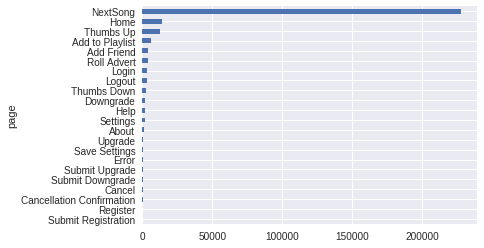

In [20]:
# Find visits for distinct users
response = spark.sql("""
    WITH user_pages AS (
        SELECT DISTINCT userId, 
                        page 
        FROM df_unique
    )
    
    SELECT page, COUNT(DISTINCT userId) AS counts
    FROM user_pages
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

distinct_view = [i.counts for i in response]

# Convert aggregated results to dataframe
df_page_vists = pd.DataFrame(dict(page = pages_non_distinct_view,
                                  distinct_view = distinct_view,
                                  non_distinct_view = non_distinct_view))

# Plot values from dataframe
ax = df_page_vists.sort_values("non_distinct_view").set_index("page")["non_distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();

We can see from this graph that users tend to use the service for playing music, obviously. They will also visit the home button a lot of times and rate music that they like. 

We can see that cancellation confirmations tend to be very unlikely, which means that our dataset after the feature engineering is complete will be imbalanced.

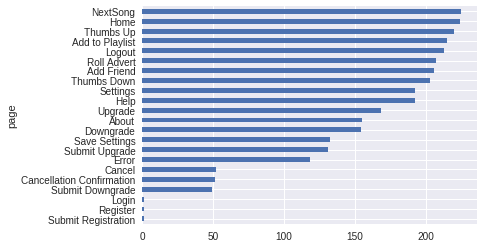

In [21]:
ax = df_page_vists.sort_values("distinct_view").set_index("page")["distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();

When we look for distinct users per page then things stop looking quite so imbalanced. We can see that out of roughly 225 registered users, roughly 50 of them end up downgrading.

I think when doing the feature engineering for this dataset, it will be worth trying to find values that provide more signal than things like "next song", which everyone does.

What's interesting is how the pages for logins, and registrations are relatively low which is something that I didn't expect.

It might be that other features are better correlated with cancellation confirmation. We want page visits that happen frequently, but not so frequently that they become meaningless.

### What location are our users mostly from?

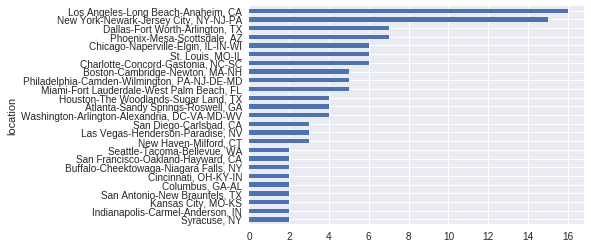

In [22]:
response = spark.sql("""
    WITH user_locations AS (
        SELECT DISTINCT userId, 
                        location 
        FROM df_unique
    )
    
    SELECT location, COUNT(DISTINCT userId) AS counts
    FROM user_locations
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 25  -- Note that without a limit, the graph will overplot
""").collect()

location = [i.location for i in response]
location_counts = [i.counts for i in response]

df_locations = pd.DataFrame(dict(location = location,
                                 location_counts = location_counts))

ax = df_locations.sort_values("location_counts").set_index("location")["location_counts"].plot(kind="barh", 
                                                                                               color=color_cycle[0])
ax.plot();

We can see that people come from various places from across the united states, Mostly the south west such as California, Texas and Arizona.

However, it seems that somehow multiple cities and areas have been combined. Making this column a little less clean than I had expected.

### What does the gender distribution of our dataset look like?

In [23]:
results_gender = spark.sql("""
    WITH user_gender AS (
        SELECT DISTINCT userId, gender
        FROM df_unique
    )

    SELECT gender, COUNT(*) AS counts
    FROM user_gender
    GROUP BY 1
    ORDER BY 1
""").collect()

results_gender

[Row(gender=None, counts=1),
 Row(gender='F', counts=104),
 Row(gender='M', counts=121)]

It seems that our gender distribution is roughly 1.16 female for every 1 male. The person with a null gender is our unregistered user.

In [24]:
# Extract gender distribution
n_males = [i.counts for i in results_gender if i.gender=='F'][0]
n_females = [i.counts for i in results_gender if i.gender=='M'][0]

n_males, n_females

(104, 121)

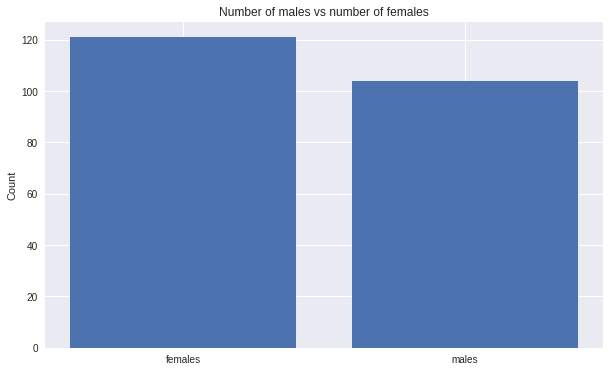

In [25]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.bar(["males", "females"], [n_males, n_females])
plt.title("Number of males vs number of females")
plt.ylabel("Count")
plt.show()

## Questions for Data Engineering

Now that we have a better feel for the data that we have been given, I want to start thinking about the feature extraction.

I would like to do a correlation plot, but that's not possible with the data in the format it it is in right now. I would need to do some feature engineering first to get everything in the right place.

So instead, I'll try and think about features that might be important and try and verify it. 

The question to be answered is "when is a user likely to unsubscribe from my services"?

* When their "use" of the platform starts to slow down.
* When they can't even use the platform due to erroes.
* When they decide to use another platform. (Not actionable)
* When they decide that they would rather save the money they spend on the service. (Not actionable)
* When friends start to ubsubscribe (network effects)
* When they listen to songs that they don't like

This means that I should check the following:

1. The distribution of those who visit the cancelation confirmation page and intra-session time.
2. Total play time per unit of time. Or even the number of pages visited per unit oftime.
3. If people are more likely to ubsubscribe if their direct friends unsubscribe.
4. Another useful signal is the number of error pages that they get. (Or event he number of times they check the help)
5. In addition to this, let's look at the ratio of likes vs dislikes.

### Find intrasession time correlation w/ cancellation

In [26]:
# Find intrasession time correlation w/ cancellation
response = spark.sql("""
    WITH usr_cancelsub AS (
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled
    FROM df_unique
    GROUP BY 1
    ),
    
    usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    )
    
    SELECT uc.*, ui.avg_intra_session_time
    FROM usr_cancelsub AS uc
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = uc.userId
""").collect()

In [27]:
intrasesh_times = [i.avg_intra_session_time for i in response]
is_canceled = [i.is_canceled for i in response]

df_intrasesh_cancelation = pd.DataFrame(dict(intrasesh_times = intrasesh_times,
                                            is_canceled = is_canceled))

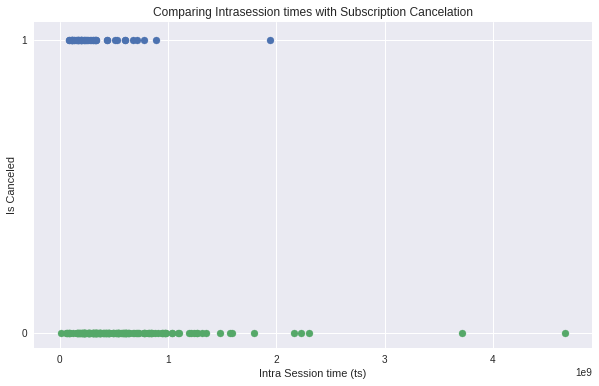

In [28]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 1]["intrasesh_times"], 
            df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 0]["intrasesh_times"], 
            df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Intrasession times with Subscription Cancelation")
plt.xlabel("Intra Session time (ts)")
plt.ylabel("Is Canceled")
plt.show()

We can see here that intrasesssion time tends to be lower for those who cancel their subscriptions. However, we are liable to get a lot of false positives if we take a simple rule that low intrasession times will cause someone to ubsubscribe. (Ofcourse, this is why we take multiple features.)

### Total play time correlation w/ Cancelation

In [29]:
# Find song long time correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(length) AS total_play_time
    FROM df_unique
    GROUP BY 1
""").collect()

In [30]:
total_play_time = [i.total_play_time for i in response]
is_canceled = [i.is_canceled for i in response]

df_playtime_cancelation = pd.DataFrame(dict(total_play_time = total_play_time,
                                            is_canceled = is_canceled))

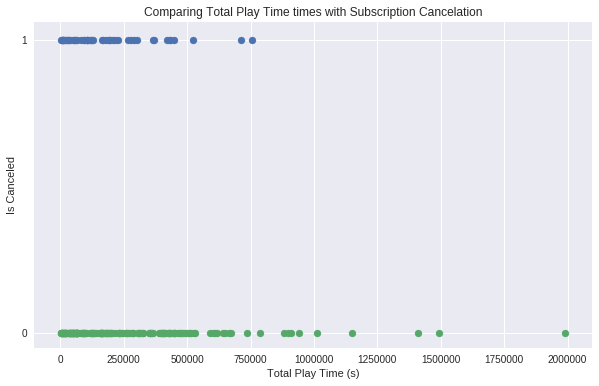

In [31]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["total_play_time"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["total_play_time"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Total Play Time times with Subscription Cancelation")
plt.xlabel("Total Play Time (s)")
plt.ylabel("Is Canceled")
plt.show()

So, it seems that this hypothesis was also true. We can see that the total amount of play time is also correlated with unsubscribing.

### Effect of network on unsubscribing

In [32]:
# Find song long time correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END) AS n_friends_added
    FROM df_unique
    GROUP BY 1
""").collect()

In [33]:
n_friends_added = [i.n_friends_added for i in response]
is_canceled = [i.is_canceled for i in response]

df_playtime_cancelation = pd.DataFrame(dict(n_friends_added = n_friends_added,
                                            is_canceled = is_canceled))

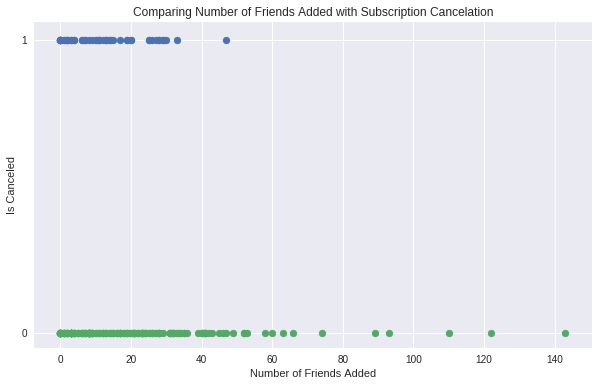

In [34]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["n_friends_added"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["n_friends_added"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Number of Friends Added with Subscription Cancelation")
plt.xlabel("Number of Friends Added")
plt.ylabel("Is Canceled")
plt.show()

Here, we can get a reoccuring theme that those with high numbers of friends are also unlikely to unsubscribe.

It seems that the reoccuring theme in these past couple of features is that the more engaged a user is with the sparkify platform, the less likely they are to unsubscribe.

### Analysis of Number of Error Pages

In [35]:
# Find error correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS n_errors
    FROM df_unique
    GROUP BY 1
""").collect()

In [36]:
n_errors = [i.n_errors for i in response]
is_canceled = [i.is_canceled for i in response]

df_errors = pd.DataFrame(dict(n_errors = n_errors,
                              is_canceled = is_canceled))

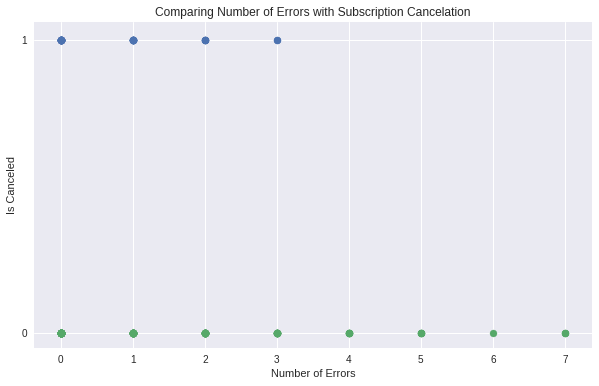

In [37]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_errors[df_errors["is_canceled"] == 1]["n_errors"], 
            df_errors[df_errors["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_errors[df_errors["is_canceled"] == 0]["n_errors"], 
            df_errors[df_errors["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Number of Errors with Subscription Cancelation")
plt.xlabel("Number of Errors")
plt.ylabel("Is Canceled")
plt.show()

We can see there that the number of errors is not strong enough of a singal to use as a feature. The number of people who have errors are relatively low AND it seems that there are people who stay described despite having more errors than those who don't.

This could just be a coincidince because the sample size is low. It is likely that this feature might still be worth having with the full dataset, but for this analysis we will leave it out.

### Ratio of Like/Dislike on unsubscribing

In [38]:
# Find error correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END)/
           SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END)AS Ratio_TU_v_TD
    FROM df_unique
    GROUP BY 1
""").collect()

In [39]:
Ratio_TU_v_TD = [i.Ratio_TU_v_TD for i in response]
is_canceled = [i.is_canceled for i in response]

df_TU_v_TD = pd.DataFrame(dict(Ratio_TU_v_TD = Ratio_TU_v_TD,
                              is_canceled = is_canceled))

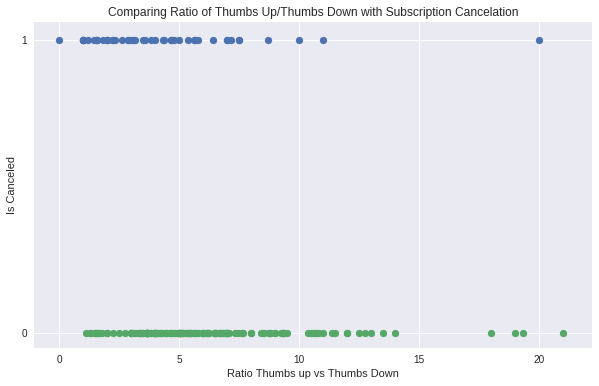

In [40]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_TU_v_TD[df_TU_v_TD["is_canceled"] == 1]["Ratio_TU_v_TD"], 
            df_TU_v_TD[df_TU_v_TD["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_TU_v_TD[df_TU_v_TD["is_canceled"] == 0]["Ratio_TU_v_TD"], 
            df_TU_v_TD[df_TU_v_TD["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Ratio of Thumbs Up/Thumbs Down with Subscription Cancelation")
plt.xlabel("Ratio Thumbs up vs Thumbs Down")
plt.ylabel("Is Canceled")
plt.show()

Once again, it seems we found another interesting feature. It seems that more people tend to upvote rather than downvote but still. 

# Part 3: Feature Engineering

In this section, the features that were most promising will be assembled into a vector to use for training the model. 

Before doing any engineering, we should consider what we want our X matrix (user-feature) and y vector (labels) to look like.

Obviously, X will be a matrix with user rows w/ features. These features will be either aggregated statistics for each user or whether they trigger some event.

Based on our EDA, we will use the following features for the columns in our X matrix:

1. Intra-session time.
2. Total play time
3. Number of Friends.
5. Ratio of likes vs dislikes.

This should give us a relatively simple model, but it should be a good start.

In [74]:
# Create SQL with Relevant Features
df_features_raw = spark.sql("""
    WITH usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    ) 

    SELECT du.userId,
           NVL(ui.avg_intra_session_time, 0) AS avg_intra_session_time,
           NVL(SUM(length), 0) AS total_play_time, 
           NVL(SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END), 0) AS n_friends_added,
           NVL(SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) /
               SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END), 0) AS Ratio_TU_v_TD,
           NVL(MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END), 0) AS label
    FROM df_unique AS du
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = du.userId
    GROUP BY 1, 2
""")

# Create Temp View
df_features_raw.createOrReplaceTempView("df_features_raw")

In [77]:
# Get columns
cols = df_features_raw.columns[1:-1]

# Create vector assembler
assembler = VectorAssembler(inputCols=cols, 
                            outputCol="DescVec")

df_features_unnormalised = assembler.transform(df_features_raw)

In [79]:
# Normalise features
scaler = Normalizer(inputCol="DescVec", outputCol="features")
df_features = scaler.transform(df_features_unnormalised).select(["features", "label"])

# Part 4: Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Create a base model

First, I want to throw my features into a model to see what kind of predictions I can get and then I want to make tweaks going from there.

In [80]:
# Perform Train Test split
train, validation = df_features.randomSplit([0.9, 0.1], seed=42)

In [81]:
# Create logistic regression
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cvModel_lr.setSeed(42)

cvModel_lr = crossval.fit(train)

In [164]:
bestModel = cvModel_lr.bestModel

In [166]:
bestModel._java_obj.getRegParam(), bestModel._java_obj.getElasticNetParam()

(0.1, 0.1)

## Evaluate Base Model

Now that we have trained our first base model, let's have a look at how it performs...

In [171]:
train_results = cvModel_lr.transform(train)

# Get Validation claffications
tp_train = train_results.filter("label = 1 and prediction = 1").count()
fp_train = train_results.filter("label = 0 and prediction = 1").count()
fn_train = train_results.filter("label = 1 and prediction = 0").count()
tn_train = train_results.filter("label = 0 and prediction = 0").count()

# Group into list
test_classifications = [tp_train, 
                        tn_train, 
                        fp_train, 
                        fn_train]

In [172]:
print_cm(*test_classifications)

[[  1   0]
 [ 47 164]]


In [173]:
get_classification_score(*test_classifications)

_________________
Confusion Matrix:
	Accuracy: 0.7783018867924528
	Precision: 1.0
	Recall: 0.020833333333333332
	F1 Score: 0.04081632653061225
_________________


In [167]:
validation_results = cvModel_lr.transform(validation)

# Get Validation claffications
tp_valid = validation_results.filter("label = 1 and prediction = 1").count()
fp_valid = validation_results.filter("label = 0 and prediction = 1").count()
fn_valid = validation_results.filter("label = 1 and prediction = 0").count()
tn_valid = validation_results.filter("label = 0 and prediction = 0").count()

# Group into list
valid_classifications = [tp_valid, 
                         tn_valid, 
                         fp_valid, 
                         fn_valid]

In [168]:
print_cm(*valid_classifications)

[[ 0  0]
 [ 3 11]]


In [169]:
get_classification_score(*valid_classifications)

_________________
Confusion Matrix:
	Accuracy: 0.7857142857142857
	Precision: nan
	Recall: 0.0
	F1 Score: nan
_________________


We can see that his model doesn't perform particularly well. Despite getting a validation accuracy of 79%, our precision and recall are either zero or undefined. 

We can see from our confusion matrix that this model simply classified all users as not churning. This will create a true negative rate that we want but it won't give us good positive results.

Even if we look at the training scores, it is not particularly great. Allthough we have good precision, our recall is pretty low meaning that there are a lot of positive examples that we are missing.

This could be because are model is relatively high bias and so making complicated judgments is relatively difficult. If we view the graphs back in the exporatory data analysis section then we can also see that there is a strong overlap between churners and non-churners, meaning that the model will likely have an easier time finding non-churners where the separation is better.

It should also be mentioned that the number of rows and features are also very low. We are working with roughly 250 observations which is not very high, so one of the first orders to do would also be to run this on the whole cluster before adding more features and then finally increasing the model complexity as a last resort.

This means that to improve this model we can do three things:


1. Move this analysis onto a cluster using the full dataset
2. Engineer more features to help distinguish between churn and non churn users
3. Use a higher variance model

# Part 5: Conclusion

## Reflection

> Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.

## Improvement

> Discussion is made as to how at least one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.

# Part 6: Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.